# Terra 0.7 New Features and Change Guide

Donny Greenberg and Matthew Treinish, 19-Dec-18

This notebook serves to highlight in code Terra and Aqua's new features and breaking changes. We highly recommend reading the [release notes](https://github.com/Qiskit/qiskit-terra/blob/master/doc/release_history.rst) for a more readable discussion, but present the below to you as a technical addendum for familiarizing yourself with the usage of the new features and updating your code for breaking changes. The examples below are intended to be exhaustive, so please raise an issue [here](https://github.com/Qiskit/qiskit-tutorials/issues) if you notice a change or break which is not included (including deprecation warnings!).

**Note:** Some of the text in this notebook does not render nicely on github. We recommend downloading the notebook, running it locally, and changing the `lin_len` variable to 200 or more.

In this notebook:
* Terra 0.7
    * Backends
    * Results
    * Visualization
    * Memory
    * Transpilation
    * Deprecations / Miscellanea

## Terra 0.7

This week's Terra release includes big updates to visualization, transpilation, backends, and memory, but fall cleaning was in full effect all over the repo.

In [28]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.qi.qi import qft
import numpy as np
import copy

In [29]:
# Setting up a Hadamard QPE circuit for demonstration.
def h_qpe(circ, q, n):
    for i in range(n-1):
        circ.h(q[i])
    for j in range(0, n-1, 2): # Only place a CH^n on every other qubit, because CX^n = I for n even
        circ.ch(q[j], q[n-1])
    circ.barrier()
    qft(circ, q, n-1)
    
n = 5
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
circuit = QuantumCircuit(qr, cr)
circuit.rx(np.pi/4, qr[n-1])
circuit.barrier()
h_qpe(circuit, qr, n)
unt_circ = copy.deepcopy(circuit)
circuit.barrier()
circuit.measure(qr, cr)

## Providers and Backends

We've split our simulator suite into three providers:

* Aer - This is our fully-featured high performance simulator suite, located in a separate repo, here (link when ready). 
* BasicAer - This is a limited-functionality version of Aer packaged inside of Terra for convenience.
* LegacySimulators - These are the older simulators from Terra 0.6-.

In [30]:
%%capture --no-display
from qiskit import BasicAer, LegacySimulators, Aer

qasm_backend = BasicAer.get_backend('qasm_simulator')
sv_backend = BasicAer.get_backend('statevector_simulator')
unt_backend = BasicAer.get_backend('unitary_simulator')

Another big change is that the "qasm_simulator" and "statevector_simulator" initialization no longer fails over to the respective python versions. 

This is because the python simulators are so limited that usually a user does not actually intend to use it, and because users often did not notice the failover and could not understand why their simulations were running so slowly.

## Results Object

We've rewritten the Results object to be a more consistent and stable interface across the backends, and with that, have moved to accessor methods rather than accessing a data object directly.

In [31]:
# Setup
from qiskit import execute

qasm_job = execute(circuit, qasm_backend)
sv_job = execute(unt_circ, sv_backend)
unt_job = execute(unt_circ, unt_backend)
qasm_result = qasm_job.result()
sv_result = sv_job.result()
unt_result = unt_job.result()

First, `result.get_data()` method has been renamed to `result.data()`, but this really shouldn't be the way you interact with results, as we'll see. This returns data as-is from the backend, so it may not be formatted into complex numbers or convenient structures.

In [32]:
qasm_result.data()

{'counts': {'0x11': 11,
  '0xb': 6,
  '0x13': 71,
  '0xf': 3,
  '0x3': 12,
  '0x15': 23,
  '0xd': 10,
  '0x1d': 60,
  '0x1': 3,
  '0x10': 125,
  '0x1f': 14,
  '0x1b': 23,
  '0x17': 1,
  '0x5': 7,
  '0x0': 655}}

In [33]:
sv_result.data()

{'counts': {'0x0': 1},
 'statevector': [[0.13529902503654992, 0.7885805074747372],
  [-0.02821286791216001, 0.04222354069865876],
  [0.0, 0.0],
  [-0.020276459301341056, 0.10193664460611457],
  [0.0, 0.0],
  [-0.013548296957796295, -0.06811188834697732],
  [0.0, 0.0],
  [-0.0056118883469774145, -0.008398784439521599],
  [0.0, 0.0],
  [0.008398784439521564, 0.005611888346977307],
  [0.0, 0.0],
  [0.06811188834697726, 0.013548296957796128],
  [0.0, 0.0],
  [-0.10193664460611465, 0.020276459301341233],
  [0.0, 0.0],
  [-0.04222354069865882, 0.028212867912160093],
  [0.05604269114599594, 0.32664074121909403],
  [0.06811188834697726, -0.1019366446061147],
  [0.0, 0.0],
  [0.04895170304220364, -0.2460968299108881],
  [0.0, 0.0],
  [0.03270848226256991, 0.16443664460611454],
  [0.0, 0.0],
  [0.013548296957796246, 0.020276459301341126],
  [0.0, 0.0],
  [-0.02027645930134109, -0.013548296957796219],
  [0.0, 0.0],
  [-0.16443664460611462, -0.03270848226256963],
  [0.0, 0.0],
  [0.246096829910888

In [ ]:
unt_result.data()
# Not displayed because results are too large for github.

The proper way to pull results is to use the new ``get_counts()``, ``get_statevector()``, and ``get_unitary()`` methods on the result object instead of ``get_data()['counts']``, ``get_data()['statevector']``, and ``get_data()['unitary']`` respectively. Note that the following results are in the familiar Terra 0.6- format.

In [35]:
qasm_result.get_counts()

{'10001': 11,
 '01011': 6,
 '10011': 71,
 '01111': 3,
 '00011': 12,
 '10101': 23,
 '01101': 10,
 '11101': 60,
 '00001': 3,
 '10000': 125,
 '11111': 14,
 '11011': 23,
 '10111': 1,
 '00101': 7,
 '00000': 655}

In [36]:
sv_result.get_statevector()

array([ 0.13529903+0.78858051j, -0.02821287+0.04222354j,
        0.        +0.j        , -0.02027646+0.10193664j,
        0.        +0.j        , -0.0135483 -0.06811189j,
        0.        +0.j        , -0.00561189-0.00839878j,
        0.        +0.j        ,  0.00839878+0.00561189j,
        0.        +0.j        ,  0.06811189+0.0135483j ,
        0.        +0.j        , -0.10193664+0.02027646j,
        0.        +0.j        , -0.04222354+0.02821287j,
        0.05604269+0.32664074j,  0.06811189-0.10193664j,
        0.        +0.j        ,  0.0489517 -0.24609683j,
        0.        +0.j        ,  0.03270848+0.16443664j,
        0.        +0.j        ,  0.0135483 +0.02027646j,
        0.        +0.j        , -0.02027646-0.0135483j ,
        0.        +0.j        , -0.16443664-0.03270848j,
        0.        +0.j        ,  0.24609683-0.0489517j ,
        0.        +0.j        ,  0.10193664-0.06811189j])

In [37]:
unt_result.get_unitary()

array([[ 0.13529903+0.78858051j,  0.        +0.j        ,
         0.        +0.j        , ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.02821287+0.04222354j, -0.47864536+0.18359683j,
         0.04222354+0.02821287j, ...,  0.0135483 -0.02027646j,
        -0.04222354+0.00111627j, -0.02027646-0.0135483j ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.44212568+0.27880531j, ...,  0.        +0.j        ,
         0.04783543-0.11548494j, -0.01981408-0.0874636j ],
       ...,
       [ 0.24609683-0.0489517j ,  0.06811189+0.03034587j,
        -0.0489517 -0.24609683j, ..., -0.06811189+0.0135483j ,
         0.08727207+0.08277646j,  0.0135483 +0.06811189j],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.2111558 +0.04783543j, ...,  0.        +0.j        ,
        -0.04783543+0.01981408j, -0.11548494+0.18313445j],
       [ 0.10193664-0.06811189j,  0.21227207+0.00561189j,
         0.06811189+0.10193664

Additionally, support for ``len()`` and indexing on a ``Result`` object has been
removed. Instead, you should interact with the output from the post-processed
methods on the Result objects.

In [38]:
len(sv_result.get_statevector())

32

The ``get_snapshot()`` and ``get_snapshots()`` methods from the ``Result`` class have been removed. Instead you can access the snapshots using ``Result.data()['snapshots']``. This is because the snapshot does not yet have a contract, so the snapshot passed back is truly at the discretion of the simulator.

In [39]:
from qiskit import LegacySimulators, Aer, compile
from qiskit.extensions.simulator.snapshot import snapshot
snap_backend = LegacySimulators.get_backend('statevector_simulator')

snap_unt_circ = copy.deepcopy(unt_circ)
snap_unt_circ.snapshot(10)
sv_job = execute(snap_unt_circ, snap_backend)
sv_result = sv_job.result()
sv_result.data()['snapshots']

/Users/donny.greenberg@ibm.com/code/qiskit-terra/qiskit/providers/legacysimulators/legacyprovider.py:41: DeprecationWarning: Simulators in the LegacySimulators provider are deprecated. If you want
 maximum compatibility, you can use those in the Simulators provider. If you want to make the most
 of performance, consider installing the Qiskit Aer element and user the Aer provider.
  warnings.warn(DEPRECATION_MSG, DeprecationWarning)
/Users/donny.greenberg@ibm.com/code/qiskit-terra/qiskit/providers/legacysimulators/legacyprovider.py:37: DeprecationWarning: Simulators in the LegacySimulators provider are deprecated. If you want
 maximum compatibility, you can use those in the Simulators provider. If you want to make the most
 of performance, consider installing the Qiskit Aer element and user the Aer provider.
  warnings.warn(DEPRECATION_MSG, DeprecationWarning)


{'statevector': {'10': [[[0.1352990250365496, 0.7885805074747372],
    [-0.02821286791216005, 0.04222354069865875],
    [4.289610691196225e-17, -3.248776605610142e-17],
    [-0.02027645930134106, 0.10193664460611457],
    [-5.397192826725481e-17, -1.1285039546789633e-16],
    [-0.013548296957796316, -0.06811188834697732],
    [-9.392163370600625e-18, 3.571064700479636e-17],
    [-0.005611888346977376, -0.00839878443952159],
    [-4.163336342344337e-17, 0.0],
    [0.008398784439521564, 0.005611888346977307],
    [-1.2627434885189043e-18, 1.167108434437975e-17],
    [0.06811188834697725, 0.013548296957796184],
    [-1.3247655120144348e-16, 1.1285039546789633e-16],
    [-0.10193664460611462, 0.020276459301341185],
    [-4.485624437213816e-18, 4.0617185938183144e-17],
    [-0.04222354069865883, 0.028212867912160114],
    [0.0560426911459959, 0.32664074121909403],
    [0.06811188834697728, -0.10193664460611472],
    [-8.375985885340412e-18, -1.283607757691177e-17],
    [0.04895170304220362,

### Averages with Respect to Observables

Lastly, `average_data(self, name, observable)` has been deprecated. It has been moved to the quantum_info section to be usable for general quantum states and observables.

In [40]:
from qiskit.quantum_info.analyzation.average import average_data

In [41]:
counts = qasm_result.get_counts()
iden = np.eye(len(counts))
oper = {}
for i, key in enumerate(counts.keys()):
    oper[key] = iden[i]
average_data(counts, oper)

array([0.01074219, 0.00585938, 0.06933594, 0.00292969, 0.01171875,
       0.02246094, 0.00976562, 0.05859375, 0.00292969, 0.12207031,
       0.01367188, 0.02246094, 0.00097656, 0.00683594, 0.63964844])

## Visualization

The biggest change made to visualization in the 0.7 release is the removal of
Matplotlib from the project requirements. This was done to simplify the
requirements and configuration required for installing Qiskit. If you plan to
use any visualizations that depend on Matplotlib, which includes the ``mpl``
output for the circuit drawer, and any of the plot* functions in the
``qiskit.tools.visualization`` module you must manually ensure that matplotlib
is installed. You can also do the following to
install Qiskit with the visualization requirements:

In [42]:
#!pip install qiskit-terra[visualization]

In [43]:
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization.dag_visualization import dag_drawer

### Circuit Drawing

We highly recommend the [Visualizing a Quantum Circuit](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/terra/visualizing_a_quantum_circuit.ipynb) notebook written by Matthew Treinish, who also wrote most of the changes proper.

The first two major changes to circuit drawing are the addition of a convenience `circuit.draw()` method to the `QuantumCircuit` object, and a no-fuss ASCII outformat. Here we're printing with a wider line to fit the full circuit (**note:** github does not allow horizontal scrolling in notebooks, so the code below does not render well there):

In [44]:
lin_len = 98
# Change to wider in Jupyter, this is only to render nicely in github
circuit.draw(line_length=lin_len)

circuit.draw() defaults to ASCII output if none is specified, but Matplotlib, Latex, and Latex source are all supported, now with even richer features than before.

Note that the ``plot_barriers`` and ``reverse_bits`` keys in the ``style`` kwarg dict are deprecated. Instead the `qiskit.tools.visualization.circuit_drawer()` kwargs ``plot_barriers`` and ``reverse_bits`` should be used instead.

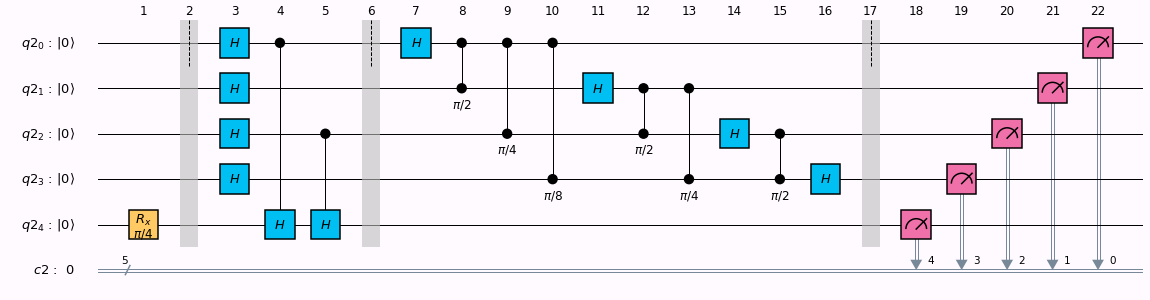

In [45]:
style = {'cregbundle': True, 'usepiformat': True, 'subfontsize': 12, 'fold': 100, 'showindex': True,
         'backgroundcolor': '#fffaff',
         "displaycolor": { # Taken from qx_color_scheme() in _circuit_visualization.py
            "id": "#ffca64",
            "u0": "#f69458",
            "u1": "#f69458",
            "u2": "#f69458",
            "u3": "#f69458",
            "x": "#a6ce38",
            "y": "#a6ce38",
            "z": "#a6ce38",
            "h": "#00bff2",
            "s": "#00bff2",
            "sdg": "#00bff2",
            "t": "#ff6666",
            "tdg": "#ff6666",
            "rx": "#ffca64",
            "ry": "#ffca64",
            "rz": "#ffca64",
            "reset": "#d7ddda",
            "target": "#00bff2",
            "meas": "#f070aa"}}
circuit.draw(output='mpl', style=style)

In [46]:
circuit.draw(output='latex_source', plot_barriers=False)

'% \\documentclass[preview]{standalone}\n% If the image is too large to fit on this documentclass use\n\\documentclass[draft]{beamer}\n% img_width = 10, img_depth = 21\n\\usepackage[size=custom,height=15,width=39,scale=0.7]{beamerposter}\n% instead and customize the height and width (in cm) to fit.\n% Large images may run out of memory quickly.\n% To fix this use the LuaLaTeX compiler, which dynamically\n% allocates memory.\n\\usepackage[braket, qm]{qcircuit}\n\\usepackage{amsmath}\n\\pdfmapfile{+sansmathaccent.map}\n% \\usepackage[landscape]{geometry}\n% Comment out the above line if using the beamer documentclass.\n\\begin{document}\n\\begin{equation*}\n    \\Qcircuit @C=0.5em @R=0.0em @!R {\n\t \t\\lstick{q2_{0}: \\ket{0}} & \\gate{H} & \\ctrl{4} & \\gate{H} & \\control\\qw & \\dstick{1.6}\\qw & \\control\\qw & \\dstick{0.79}\\qw & \\control\\qw & \\dstick{0.39}\\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\meter & \\qw & \\qw\\\\\n\t \t\\lstick{q2_{1}: \\ke

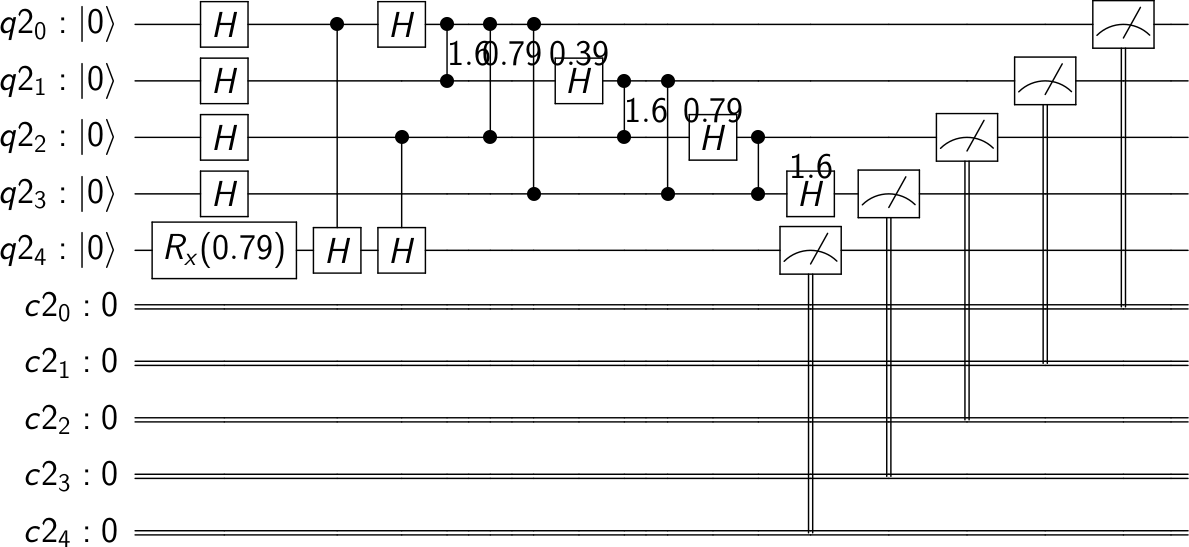

In [47]:
circuit.draw(output='latex', plot_barriers=False)

circuit_drawer(circuit) can still be used as expected.

However, the ``basis`` kwarg in the ``circuit_drawer()`` function has been removed, and the canonical way to do this now by simply transpiling first:

In [48]:
from qiskit import transpiler

In [ ]:
draw_circ = transpiler.transpile(circuit, qasm_backend, basis_gates='U,CX')
draw_circ.draw(line_length=2000)
# Not shown in github for rendering reasons, load in Jupyter

Note that moving forward, `circuit.draw()` and the ``circuit_drawer()`` function will be the sole interfaces
for circuit drawing in the visualization module. ``plot_circuit()``, ``latex_circuit_drawer()``, ``generate_latex_source()``, and ``matplotlib_circuit_drawer()`` from qiskit.tools.visualization in 0.6 are
deprecated. Instead the ``circuit_drawer()`` function from the same module
should be used, and there are kwarg options to mirror the functionality of all
the deprecated functions.

### State Visualization

Frist, `plot_state()` and `iplot_state()` have been depreciated. Instead the functions `plot_state_*()` and `iplot_state_*()` should be called for the visualization method required, as you'll see below.

Second, the output of the `plot_state_*()` functions have changed. Previously, calling these functions would open up new windows (depending on matplotlib backend) to display the visualizations. Now, they return a ``matplotlib.Figure`` object, which provides much more flexibility to interact with the visualization prior to saving or showing it.

Starting in the 0.7 you'll need to call ``show()`` on the output to mirror the previous behavior. In notebooks, we'll just return the figure, so mpl will display normally.

In [50]:
from qiskit.tools.qi.qi import outer
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_bloch_multivector, plot_state_paulivec, plot_state_hinton, plot_state_qsphere
from qiskit.tools.visualization import iplot_histogram, iplot_state_city, iplot_bloch_multivector, iplot_state_paulivec, iplot_state_hinton, iplot_state_qsphere

In [51]:
counts = qasm_result.get_counts()
phi = sv_result.get_statevector()
rho = outer(phi)

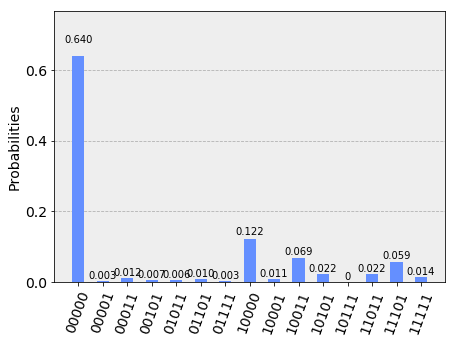

In [52]:
plot_histogram(counts)

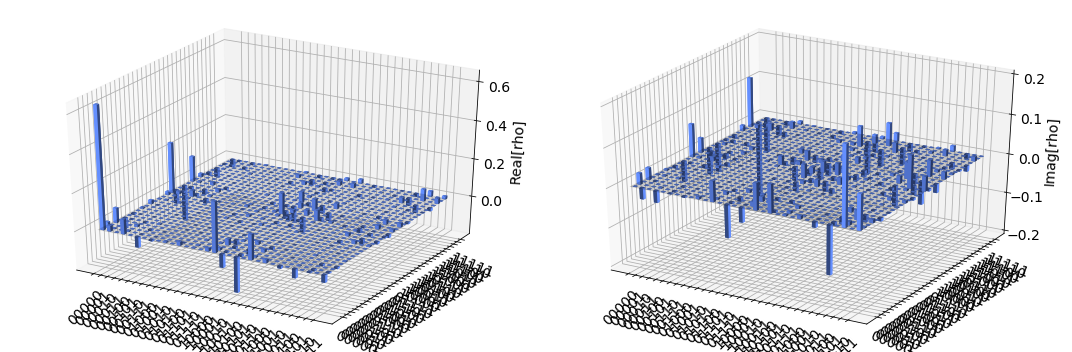

In [53]:
plot_state_city(rho)

We also have add hinton diagrams as a new diagram type:

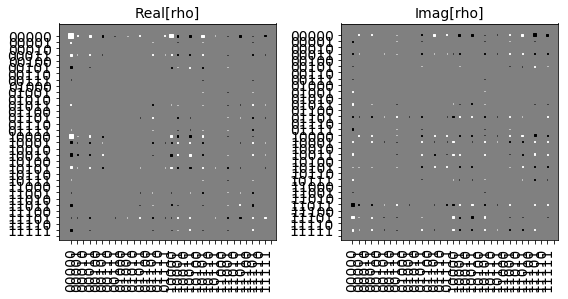

In [54]:
plot_state_hinton(rho)

Returning the Figure object provides additional flexibility for dealing
with the output. 

For example instead of just showing the figure you can now
directly save it to a file by leveraging the ``savefig()`` method. For example::

In [55]:
hist_fig = plot_histogram(counts)
state_fig = plot_state_city(rho)
hist_fig.savefig('histogram.png')
state_fig.savefig('state_plot.png')

The other key aspect which has changed with these functions is when running
under jupyter. In the 0.6 release ``plot_state()`` and ``plot_histogram()``
when running under jupyter the default behavior was to use the interactive
Javascript plots if the externally hosted Javascript library for rendering
the visualization was reachable over the network. If not it would just use
the matplotlib version. However in the 0.7 release this no longer the case,
and separate functions for the interactive plots, ``iplot_state()`` and
``iplot_histogram()`` are to be used instead. ``plot_state()`` and
``plot_histogram()`` always use the matplotlib versions.

In [ ]:
iplot_bloch_multivector(rho)
# Not displayed in github, download and run loacally.

Additionally, starting in this release the ``plot_state()`` function is
deprecated in favor of calling individual methods for each method of plotting
a quantum state. While the ``plot_state()`` function will continue to work
until the 0.9 release, it will emit a warning each time it is used. The

```
==================================  ========================
Qiskit Terra 0.6                    Qiskit Terra 0.7+
==================================  ========================
plot_state(rho)                     plot_state_city(rho)
plot_state(rho, method='city')      plot_state_city(rho)
plot_state(rho, method='paulivec')  plot_state_paulivec(rho)
plot_state(rho, method='qsphere')   plot_state_qsphere(rho)
plot_state(rho, method='bloch')     plot_bloch_multivector(rho)
plot_state(rho, method='hinton')    plot_state_hinton(rho)
==================================  ========================
```

The same is true for the interactive JS equivalent, ``iplot_state()``. The
function names are all the same, just with a prepended `i` for each function.
For example, ``iplot_state(rho, method='paulivec')`` is
``iplot_state_paulivec(rho)``.

Lastly, we now have a DAGCircuit drawer too!

In [57]:
from qiskit.converters.circuit_to_dag import circuit_to_dag

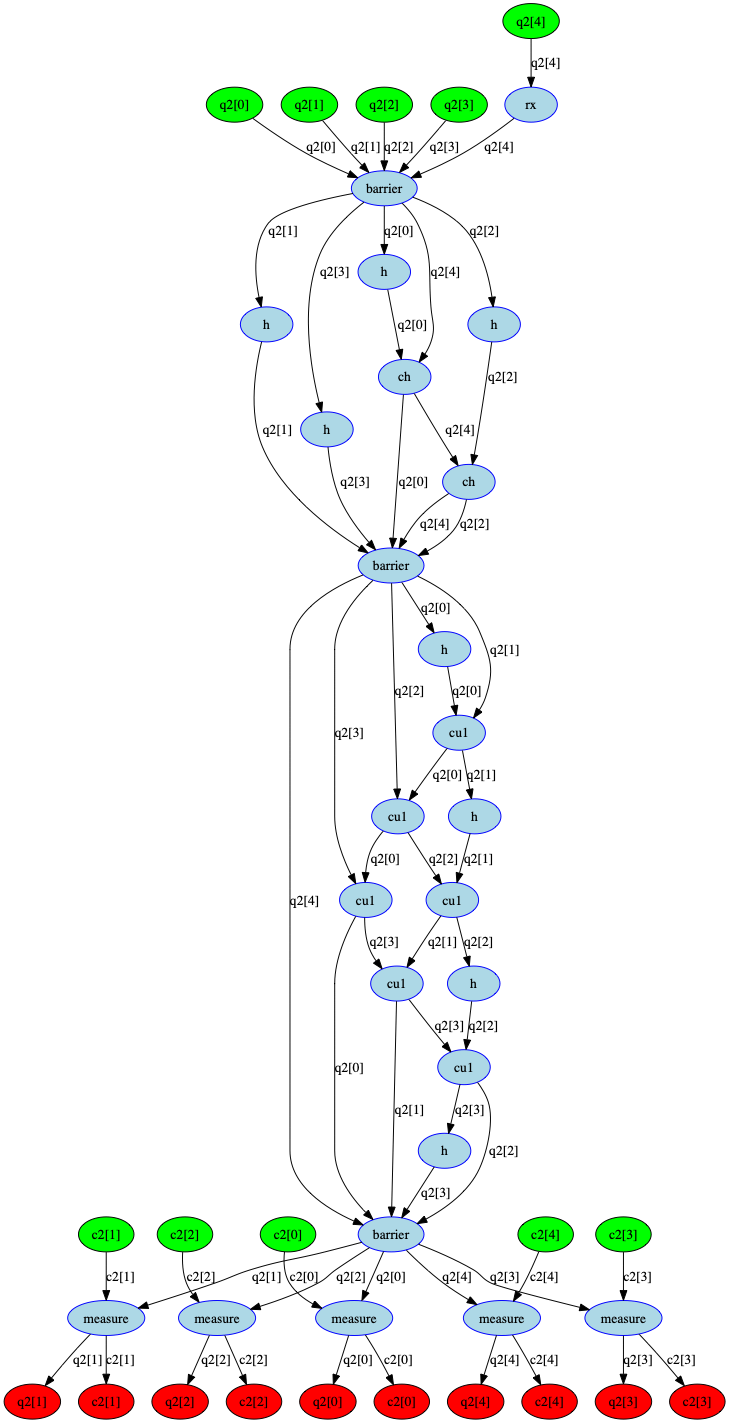

In [58]:
my_dag = circuit_to_dag(circuit)
dag_drawer(my_dag)

## Shot Memory

Shot memory is a complete log of shot results when you run on Quantum hardware or shot-based simulators. This is critical for characterization and analysis of hardware behavior, and a frequently requested feature. 

To use shot memory, simply set memory=True in your execute call:

In [59]:
job = execute(circuit, qasm_backend, shots=50, memory=True)

result = job.result()
result.get_memory(circuit)

['00000',
 '00000',
 '00000',
 '10000',
 '11011',
 '00000',
 '00000',
 '10000',
 '01101',
 '00000',
 '00000',
 '00000',
 '00000',
 '11111',
 '00011',
 '00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '10101',
 '10000',
 '00000',
 '10011',
 '00000',
 '00000',
 '00000',
 '10000',
 '10101',
 '00000',
 '10101',
 '10011',
 '00000',
 '10001',
 '00000',
 '00000',
 '01111',
 '00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '11101',
 '11111']

## Transpilation and the DAGCircuit

The transpiler is the workhorse of Terra. It’s how we keep circuits backend agnostic and compilable for arbitrary quantum hardware. The transpiler in Terra .6 was not transparent or extensible enough for increasingly sophisticated transpilation methods, so we tore it down and rewrote it to be much more robust.

The transpiler now transpiles circuits into circuits, rather than into DAGCircuits. This is much more transparent, and allows the end user to view and understand what individual transpiler passes are doing to their circuit. Here's a sample circuit that won't fit nicely on IBM's hardware (our QPE circuit had nearest neighbor connections, so these qubit remappers won't do much):

In [60]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasicSwap, CXCancellation, LookaheadSwap, StochasticSwap
from qiskit.transpiler import transpile
from qiskit.mapper import CouplingMap

In [61]:
qr = QuantumRegister(7, 'q')
qr = QuantumRegister(7, 'q')
tpl_circuit = QuantumCircuit(qr)
tpl_circuit.h(qr[3])
tpl_circuit.cx(qr[0], qr[6])
tpl_circuit.cx(qr[6], qr[0])
tpl_circuit.cx(qr[0], qr[1])
tpl_circuit.cx(qr[3], qr[1])
tpl_circuit.cx(qr[3], qr[0])
tpl_circuit.draw()

The most naive thing we can do is simply move qubits around greedily with swaps. Let’s see how the BasicSwap pass does here:

In [62]:
coupling = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]

simulator = BasicAer.get_backend('qasm_simulator')
coupling_map = CouplingMap(couplinglist=coupling)
pass_manager = PassManager()
pass_manager.append([BasicSwap(coupling_map=coupling_map)])
basic_circ = transpile(tpl_circuit, simulator, pass_manager=pass_manager)
basic_circ.draw()

Not great. Let’s try Sven Jandura's LookaheadSwap, submitted for the 2018 QISKit
Developer Challenge. Sven’s swap pass was merged into Terra, and we will have two more passess from other winners of the Qiskit Developer Challenge soon! We’re constructing a diverse set of passes, many user contributed, to meet the wide-ranging needs and mapping scenarios of circuits in the wild.

In [63]:
pass_manager = PassManager()
pass_manager.append([LookaheadSwap(coupling_map=coupling_map)])
lookahead_circ = transpile(tpl_circuit, simulator, pass_manager=pass_manager)
lookahead_circ.draw()

Better! One more try with the StochasticSwap:

In [64]:
pass_manager = PassManager()
pass_manager.append([StochasticSwap(coupling_map=coupling_map)])
stoch_circ = transpile(tpl_circuit, simulator, pass_manager=pass_manager)
stoch_circ.draw()

Even better, but still more room to go. Right now this all happens behind the scenes for many users, but we hope that these tools make digging into transpilation much more accessible to those attempting to squeeze as much performance as possible out of their experiments on hardware.

### PassManager

Another big overhaul in 0.7 was a rewrite of the PassManager. Applying and chaining transpiler passes is now much more straightforward and extensible, but this is too large a topic for us to cover in this notebook. 

Luckily, Ali Javadi-Abhari, who wrote much of the transpiler update, will be posting a “Writing a Transpiler Pass” blog post soon to cover this topic.

### `skip_transpiler`

The ``skip_transpiler`` arg has been deprecated from ``compile()`` and ``execute()``. Instead, you should simply pass an empty PassManager to `execute()`, `compile()`, or `transpile()`, like so:

In [65]:
qasm_job = execute(circuit, qasm_backend, pass_manager=PassManager())

### Converters and ``transpile_dag()``

We've introduced a suite of converters to convert between common circuit formats, namely QuantumCircuit, DAGCircuit, Qobj, and ast.

The ``transpile_dag()`` function ``format`` kwarg for emitting different output formats is deprecated, instead you should convert the default output ``DAGCircuit`` object to the desired format.

In [66]:
from qiskit.converters.dag_to_circuit import dag_to_circuit

In [67]:
new_circ_from_dag = dag_to_circuit(my_dag)
new_circ_from_dag.draw(line_length = lin_len)

### Unrolling

The unrollers have been deprecated in favor of unrolling in the transpiler. This is more straightforward and a more natural place for unrolling. Moving forward only DAG to DAG unrolling will be supported, as was shown above in the discussion of the deprecation of the "basis" argument to the circuit_drawer:

```
    draw_circ = transpiler.transpile(circuit, qasm_backend, basis_gates='U,CX')
```

## Other Deprecations and Miscellanea

### Loading QASM into Circuits

The `qiskit.wrapper.load_qasm_string()` and `qiskit.wrapper.load_qasm_file()`
  functions are deprecated. The following QuantumCircuit constructor methods should be used instead:

In [68]:
from qiskit import QuantumCircuit

In [69]:
qasm_str = circuit.qasm()
new_circ = QuantumCircuit.from_qasm_str(qasm_str)
new_circ.draw(line_length = lin_len)

In [70]:
filepath = 'my_qasm_file.txt'
qasm_file = open(filepath, "w")
qasm_file.write(unt_circ.qasm())
qasm_file.close()

new_unt_circ = QuantumCircuit.from_qasm_file(filepath)
new_unt_circ.draw(line_length = lin_len)